In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import math
import time
import sys
%matplotlib inline

In [2]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        #self.node = [ np.random.randn(num_node,1) for num_node in layer_node ]
        self.weights = [ np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_value = self.input_node
        for weight in self.weights: 
            #print weight.shape
            #print output_vector.shape
            s = np.dot(weight, output_value)
            #print "forward"
            output_value = np.append([[1]], activation_function(s), axis=0) # add bias node -> size (n+1,1)
        #print "out:",output_vector
        #print output_value[1:][0][0]
        return np.sign(output_value[1:][0][0]) # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]
        #print len(sensitivity)
        
        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            #print "back"
            x.append(np.append([[1]], activation_function(s[-1]), axis=0))
        #print x[-1][1:]
        #print np.square(x[-1][1:])
        sensitivity[-1] = 2.0*(x[-1][1:] - output_vector)*(1-np.square(x[-1][1:])) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]
            #print w
            #print w.shape
            #print sensitivity[-layer_index+1].shape
            
            sensitivity[-layer_index] = (1-np.square(x[-layer_index][1:]))*(np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0
            
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs, print_message=True, visualize=True): #stochastic gradient descent
        error_ratio_list = []
        error_ratio = 0
        error_count = 0
        predicted_result = []
        result_df = None
        
        for epoch in xrange(epochs): 
            gradient = [np.zeros(w.shape) for w in self.weights]
            #gradient = [ np.random.randn(next_node,previous_node+1) 
                            #for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)
                
                #print "sens ", len(sensitivity)
                #print "x ", len(x)
                #break
                
                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
           
            #print "epoch ",epoch+1
            
            error_ratio, error_count, predicted_result = self.evaluate(testing_data)
            error_ratio_list.append(error_ratio)
     
            #print "Epoch {0}: MSE = {1}".format(epoch+1, MSE)
            #print
        if print_message:
            print "Error count = {0}/{1}".format(error_count[0,0], testing_data.shape[0])
            print "Error ratio = ", error_ratio_list[-1]

        if visualize: 
            result_df = visualization(testing_data, error_ratio_list, predicted_result)
        
        return error_ratio_list, predicted_result, result_df
    
    
    
    def evaluate(self,testing_data):
        error_count = 0
        predicted_result = []
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_vector = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_value = self.forward_propagation()
            #print type(predicted_value)
            predicted_result.append(predicted_value)
            #print predicted_vector, output_vector
            #print "decision :", predicted_vector != output_vector
            error_count += predicted_value != output_vector #np.abs(predicted_vector - output_vector)
            #print predicted_value
        return float(error_count)/testing_data.shape[0], error_count, predicted_result

            

In [3]:
def visualization(df, MSE, predicted_result): 
    data = df.copy()
    data['Predicted'] = predicted_result

    plt.figure(1)
    plt.plot(MSE)
    plt.title("Error Ratio Plot")
    
    colormap = np.array(['b','b' ,'r'])
    
    plt.figure(2)
    plt.scatter(data.x, data.y, c=colormap[data.Class], s=40)
    plt.title("True Plot")
    
    plt.figure(3)
    plt.scatter(data.x, data.y, c=colormap[data.Predicted], s=40)
    plt.title("Predicted Plot")
    
    plt.show()
    
    return data

In [4]:
def activation_function(z): 
    return np.tanh(z) # sigmoid function tanh

#### Create dataframe

In [5]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [6]:
def z_score(df):
    new_df = df.copy()
    new_df.x = (new_df.x - new_df.x.mean())/new_df.x.std(ddof=0)
    new_df.y = (new_df.y - new_df.y.mean())/new_df.y.std(ddof=0)
    return new_df

In [7]:
df = pd.read_csv('donneespb4.txt',sep=' ',header=None)
df.columns = ['x','y','Value']
df = str_to_float(df)
df = z_score(df) 
binary_code = [np.sign(x-.5) for x in df.Value] 
df['Class'] = binary_code 
df = df.drop('Value',1)
df.head()

,x,y,Class
0,1.064435,-1.267294,1
1,-1.016185,-0.788290,-1
2,-1.056870,-0.637423,-1
3,-1.011227,0.242393,-1
4,0.067787,1.517892,1


C:\Users\tphan.ENSC\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\tphan.ENSC\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


Error count = 35/3000
Error ratio =  0.0116666666667


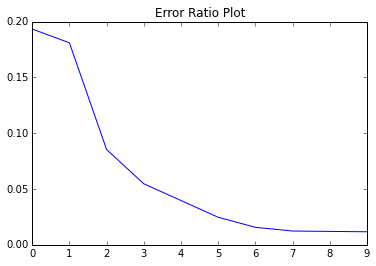

C:\Users\tphan.ENSC\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


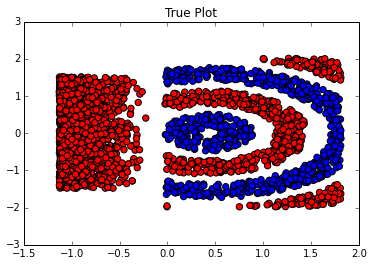

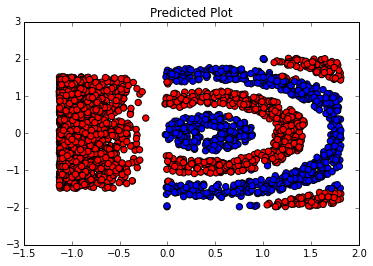

Processing time: 4.13468392435 seconds


In [8]:
net = Network([2,30,1])
t0 = time.clock()
MSE_list, predicted_result, result_df = net.SGD(df,df,0.01,10)
print "Processing time: {0} seconds".format((time.clock() - t0))

#### 10-fold Cross-validation

In [9]:
from sklearn.cross_validation import KFold

In [10]:
def kfold_neural_net(neural_net, n_folds, data, eta, epochs, print_message=True):
    kf = KFold( n=data.shape[0], n_folds=n_folds, shuffle=False,random_state=None)
    cumulative_MSE = 0
    counter = 1 
    for train_index, test_index in kf:
        net = Network(neural_net)
        train_set = data.iloc[train_index,:]
        test_set = data.iloc[test_index,:]
        if print_message:
            print "----Iteration {0}----".format(counter)
        MSE_list, predicted_result, result_df = net.SGD(training_data = train_set, testing_data = test_set, 
                    eta = eta, epochs = epochs, print_message = print_message,visualize = False)
        cumulative_MSE += MSE_list[-1]
        counter += 1
        if print_message: 
            print
        
    average_error_ratio = cumulative_MSE/float(n_folds)
    if print_message: 
        print "Average error ratio = ", average_error_ratio
    return average_error_ratio

In [11]:
kfold_neural_net(neural_net=[2,30,1], n_folds=10,data=df,eta=0.01,epochs=5)

----Iteration 1----
Error count = 15/300
Error ratio =  0.05

----Iteration 2----
Error count = 15/300
Error ratio =  0.05

----Iteration 3----
Error count = 23/300
Error ratio =  0.0766666666667

----Iteration 4----
Error count = 40/300
Error ratio =  0.133333333333

----Iteration 5----
Error count = 10/300
Error ratio =  0.0333333333333

----Iteration 6----
Error count = 8/300
Error ratio =  0.0266666666667

----Iteration 7----
Error count = 13/300
Error ratio =  0.0433333333333

----Iteration 8----
Error count = 5/300
Error ratio =  0.0166666666667

----Iteration 9----
Error count = 42/300
Error ratio =  0.14

----Iteration 10----
Error count = 40/300
Error ratio =  0.133333333333

Average error ratio =  0.0703333333333


0.07033333333333333

#### Parameters seletion

In [48]:
learning_rate = np.linspace(0.001,1,50)
#iterations = range(10,300,50)
neuron_num = range(0,65,10)[1:]

iteration_lst = []
for x in xrange(learning_rate.shape[0]):
    iteration_lst.extend(iterations)
#iterations_list = iterations. for x in xrange(learning_rate.shape[0])]

In [49]:
learning_rate_lst = []
for x in xrange(len(neuron_num)):
    #temp_list = [eta] * len(neuron_num)
    #learning_rate_lst.extend(temp_list)
    learning_rate_lst.extend(learning_rate)

In [50]:
len(learning_rate_lst)

300

In [51]:
neuron_num_list = []
for num in neuron_num:
    temp_list = [num] * len(learning_rate)
    neuron_num_list.extend(temp_list)

In [52]:
len(neuron_num_list)

300

iteration_list = []
learning_rate_list = []

for x in xrange(len(neuron_num)):
    iteration_list.extend(iteration_lst)
    learning_rate_list.extend(learning_rate_lst)

In [53]:
#parameter_df = pd.DataFrame(columns=['Neuron_number','Learning_rate','Iteration','Error ratio'])
parameter_df = pd.DataFrame(columns=['Neuron_number','Learning_rate','Error ratio'])

In [54]:
len(neuron_num_list)

300

In [55]:
parameter_df['Neuron_number'] = neuron_num_list
#parameter_df['Iteration'] = iteration_list
parameter_df['Learning_rate'] = learning_rate_lst

In [56]:
parameter_df.head()

,Neuron_number,Learning_rate,Error ratio
0,10,0.001000,NaN
1,10,0.021388,NaN
2,10,0.041776,NaN
3,10,0.062163,NaN
4,10,0.082551,NaN


In [61]:
def parameter_testing(df, parameter_df):
    new_parameter_df = parameter_df.copy()
    min_error_ratio = np.Inf
    best_row = None
    for index, row in new_parameter_df.iterrows():
        print "Calculating ({0}/{1})...".format(index+1,new_parameter_df.shape[0]) 
        print 
        sys.stdout.flush()
        time.sleep(.2) 
        
        #net = Network([2,row.Neuron_number,1])
        layers = [2,row.Neuron_number,1]
        average_error_ratio = kfold_neural_net(neural_net=layers, n_folds=10, data=df, eta=row.Learning_rate, epochs= 50, 
                                      print_message=False)
        row.Error_ratio = average_error_ratio
        
        if average_error_ratio < min_error_ratio: 
            min_error_ratio = average_error_ratio
            best_row = row 
            print "New best error ratio: ",average_error_ratio
            print "   Number of neurons in the hidden layer: ", row.Neuron_number
            print "   Learning rate: ", row.Learning_rate
            #print "   Number of iteration: ", row.Iteration
            print
        sys.stdout.flush()
        time.sleep(.2) 
    
    print "----------------------------------------------------------"
    print "Best error ratio: ",min_error_ratio
    print "Number of neurons in the hidden layer: ", best_row.Neuron_number
    print "Learning rate: ", best_row.Learning_rate
    print "----------------------------------------------------------"
        
    return new_parameter_df, best_row

In [ ]:
t0 = time.clock()
param_df, best_param = parameter_testing(df=df, parameter_df=parameter_df)
print "Processing time: {0} seconds".format((time.clock() - t0))

Calculating (1/300)...

